# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
%matplotlib inline

In [20]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.tail()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
46202,79494,10,1,61.0,CONSUMER,9,27.27,BYO,7,0,...,NO-CONTRACT,0,OTHER,0,27.27,COUNTRY,VIC,0.0,1.0,0.0
46203,79495,2,1,53.0,CONSUMER,2,54.54,NON BYO,2,0,...,OFF-CONTRACT,24,UNKNOWN,1,54.99,METRO,NSW,NaN,NaN,NaN
46204,79496,47,1,22.0,CONSUMER,47,72.72,NON BYO,7,17,...,ON-CONTRACT,24,APPLE,0,72.72,COUNTRY,NSW,0.0,0.0,0.0
46205,79497,94,1,40.0,CONSUMER,182,17.27,NON BYO,4,0,...,OFF-CONTRACT,24,APPLE,0,17.27,METRO,VIC,0.0,0.0,0.0
46206,79500,0,1,24.0,CONSUMER,0,36.36,BYO,0,0,...,NO-CONTRACT,0,APPLE,0,36.36,METRO,NSW,0.0,0.0,0.0


In [21]:
churn = churn.drop(['COUNTRY_METRO_REGION', 'STATE' , 'RECON_SMS_NEXT_MTH' , 'RECON_TELE_NEXT_MTH' , 'RECON_EMAIL_NEXT_MTH' , 'HANDSET_USED_BRAND'], axis = 1)
churn
# Removing the recon and other unwanted columns

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND
INDEX,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,OFF-CONTRACT,24,1,61.40
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,OFF-CONTRACT,24,1,54.54
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,OFF-CONTRACT,12,1,2.50
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,OFF-CONTRACT,24,1,6.48
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,OFF-CONTRACT,24,1,100.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46202,79494,10,1,61.0,CONSUMER,9,27.27,BYO,7,0,0,NO-CONTRACT,0,0,27.27
46203,79495,2,1,53.0,CONSUMER,2,54.54,NON BYO,2,0,24,OFF-CONTRACT,24,1,54.99
46204,79496,47,1,22.0,CONSUMER,47,72.72,NON BYO,7,17,24,ON-CONTRACT,24,0,72.72


In [22]:
churn.shape

(46206, 15)

In [23]:
print("No. of samples for 0 CHURN_IND: ", churn[churn['CHURN_IND'] == 0].shape[0])
print("No. of samples for 1 CHURN_IND: ", churn[churn['CHURN_IND'] == 1].shape[0])

No. of samples for 0 CHURN_IND:  28416
No. of samples for 1 CHURN_IND:  17790


In [24]:
churn = churn.fillna(method='bfill')

#used bfill function to fill the NA values in the dataset

In [34]:
churn.CFO.replace({"CONSUMER":1, "SMALL BUSINESS":0}, inplace = True)
churn.BYO_PLAN_STATUS.replace({"BYO":1, "NON BYO":0}, inplace = True)

AttributeError: 'DataFrame' object has no attribute 'CFO'

In [168]:
dummy_churn = pd.get_dummies(churn)

In [169]:
dummy_churn.tail(15)

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,CONTRACT_STATUS_NO-CONTRACT,CONTRACT_STATUS_OFF-CONTRACT,CONTRACT_STATUS_ON-CONTRACT
INDEX,,,,,,,,,,,,,,,,,
46192,79474,28,1,51.0,1,28,45.44,0,22,2,24,0,1,58.16,0,0,1
46193,79475,0,1,45.0,1,0,54.54,0,0,24,24,0,0,54.69,0,0,1
46194,79477,29,1,21.0,1,29,63.63,1,2,0,24,24,1,80.44,0,1,0
46195,79478,52,1,22.0,1,52,54.54,0,3,21,24,24,0,109.08,0,0,1
46196,79480,54,2,44.0,1,6,54.54,0,6,18,24,0,1,54.54,0,0,1
46197,79484,8,2,74.0,1,8,36.36,0,8,16,24,0,0,48.17,0,0,1
46198,79486,93,1,88.0,1,160,17.27,0,3,0,0,0,0,17.27,1,0,0
46199,79487,68,4,51.0,0,48,72.72,0,17,2,24,24,0,68.18,0,0,1
46200,79488,6,2,29.0,1,1,72.72,0,1,23,24,0,0,119.64,0,0,1


In [187]:
dummy_churn = dummy_churn.drop(['CONTRACT_STATUS_OFF-CONTRACT'], axis = 1)

# dropped two dummy columns as a part of preprocessing

In [188]:
y = dummy_churn.CHURN_IND.values
X = dummy_churn.drop(['CHURN_IND' , 'CUST_ID'], axis = 1)
cols = X.columns
cols

Index(['ACCOUNT_TENURE', 'ACCT_CNT_SERVICES', 'AGE', 'CFU', 'SERVICE_TENURE',
       'PLAN_ACCESS_FEE', 'BYO_PLAN_STATUS', 'PLAN_TENURE',
       'MONTHS_OF_CONTRACT_REMAINING', 'LAST_FX_CONTRACT_DURATION',
       'PREV_CONTRACT_DURATION', 'MONTHLY_SPEND',
       'CONTRACT_STATUS_NO-CONTRACT', 'CONTRACT_STATUS_ON-CONTRACT'],
      dtype='object')

In [189]:
scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(X)
standard_df = pd.DataFrame(standard_df) 

In [190]:
standard_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.003790,-0.665103,-0.747537,0.426769,-0.083170,0.152247,-0.549995,0.425116,-0.987499,0.454310,0.796700,-0.187546,-0.366251,-1.256081
1,0.427038,1.728616,0.890068,0.426769,0.167191,0.152247,-0.549995,-0.598448,-0.987499,0.454310,0.796700,-0.280856,-0.366251,-1.256081
2,0.578198,-0.665103,-0.813042,0.426769,0.282742,-0.501787,1.818198,0.425116,-0.987499,-1.039241,-0.295913,-0.988707,-0.366251,-1.256081
3,-0.449689,-0.665103,0.628052,0.426769,-0.372049,-0.937649,-0.549995,2.062819,-0.987499,0.454310,0.796700,-0.934571,-0.366251,-1.256081
4,1.485157,-0.665103,-0.682033,0.426769,0.860499,0.152247,-0.549995,-1.110230,-0.987499,0.454310,0.796700,0.340487,-0.366251,-1.256081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46201,-1.084561,-0.665103,1.283094,0.426769,-0.795737,-1.155341,1.818198,-0.393735,-0.987499,-2.532791,-1.388527,-0.651784,2.730365,-1.256081
46202,-1.326416,-0.665103,0.759060,0.426769,-0.930547,0.152247,-0.549995,-0.905518,-0.987499,0.454310,0.796700,-0.274735,-0.366251,-1.256081
46203,0.034022,-0.665103,-1.271571,0.426769,-0.063912,1.023972,-0.549995,-0.393735,1.050531,0.454310,0.796700,-0.033570,-0.366251,0.796127
46204,1.454925,-0.665103,-0.092495,0.426769,2.535993,-1.634838,-0.549995,-0.700805,-0.987499,0.454310,0.796700,-0.787805,-0.366251,-1.256081


In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 24)

In [192]:
print('X_train_shape:', X_train.shape)
print('y_train_shape:', y_train.shape)
print('X_test_shape:', X_test.shape)
print('y_test_shape:', y_test.shape)

X_train_shape: (34654, 14)
y_train_shape: (34654,)
X_test_shape: (11552, 14)
y_test_shape: (11552,)


In [193]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [194]:
model = LogisticRegression()
model.fit(X_test, y_test)

LogisticRegression()

In [195]:
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

In [196]:
print("Accuracy score on training set:", accuracy_score(y_train, y_hat_train))
print("Accuracy score on testing set:", accuracy_score(y_test, y_hat_test))

Accuracy score on training set: 0.718300917642985
Accuracy score on testing set: 0.7200484764542936


In [197]:
print("Confusion matrix on test set:")
confusion_matrix(y_test, y_hat_test)

Confusion matrix on test set:


array([[5844, 1243],
       [1991, 2474]])

In [198]:
lr_model = LogisticRegression()
rfe = RFE(estimator=lr_model, n_features_to_select=5, step=1)
rfe.fit(X_train, y_train)


RFE(estimator=LogisticRegression(), n_features_to_select=5)

In [199]:
y_test_hat = rfe.predict(X_test)
print("accuracy score on test set: ", accuracy_score(y_test, y_hat_test))

accuracy score on test set:  0.7200484764542936


In [200]:
for i in range(X_train.shape[1]):
    print('Column: %d, selected %s, rank: %.3f' % (i,  rfe.support_[i], rfe.ranking_[i]))

Column: 0, selected False, rank: 10.000
Column: 1, selected False, rank: 7.000
Column: 2, selected False, rank: 4.000
Column: 3, selected True, rank: 1.000
Column: 4, selected False, rank: 6.000
Column: 5, selected False, rank: 9.000
Column: 6, selected True, rank: 1.000
Column: 7, selected False, rank: 8.000
Column: 8, selected True, rank: 1.000
Column: 9, selected False, rank: 2.000
Column: 10, selected False, rank: 3.000
Column: 11, selected False, rank: 5.000
Column: 12, selected True, rank: 1.000
Column: 13, selected True, rank: 1.000


In [201]:
acc_scores = []
for i in range(1,10):
    clf = LogisticRegression()
    rfe = RFE(estimator=clf, n_features_to_select=i)
    # training model
    rfe.fit(X_train, y_train)
    # predicting on test set
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    # print this
    print("Acc on test set using", i, "features: ", acc_score)
    # append to the list
    acc_scores.append(acc_score)

Acc on test set using 1 features:  0.6375519390581718
Acc on test set using 2 features:  0.6573753462603878
Acc on test set using 3 features:  0.6573753462603878
Acc on test set using 4 features:  0.6573753462603878
Acc on test set using 5 features:  0.6573753462603878
Acc on test set using 6 features:  0.6481994459833795
Acc on test set using 7 features:  0.6488054016620498
Acc on test set using 8 features:  0.6728704986149584
Acc on test set using 9 features:  0.7091412742382271


In [202]:
import warnings
warnings.filterwarnings('ignore')

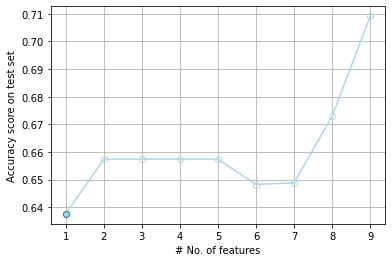

In [203]:
estimator = LogisticRegression()
acc_scores = []
for i in range(1, 10):
    selector = RFE(estimator, i)
    selector = selector.fit(X_train, y_train)
    supp = selector.get_support()

    predicted = selector.predict(X_test)
    acc_score = accuracy_score(y_test, predicted)
    acc_scores.append(acc_score)
  
best = 1
for item in acc_scores:
    if item < acc_scores[best - 1]:
        best = acc_scores.index(item) + 1

plt.grid()   
plt.xlabel('# No. of features')
plt.ylabel('Accuracy score on test set')
plt.plot(range(1, 10), acc_scores, marker = 'o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'lightblue', markerfacecolor = 'None')
plt.plot(best, acc_scores[best-1], marker = 'o', markerfacecolor = 'lightblue')